In [1]:
%matplotlib inline
import seaborn as sns; 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import datetime
from io import StringIO
import re
import numpy as np
from datetime import datetime
import apt_pkg
apt_pkg.init_system()
from tqdm import tqdm_notebook as tqdm
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

In [2]:
sns.set_style('ticks',{'legend.frameon':True} )
sns.set_palette('colorblind')
FIG_SIZE = (12, 3)
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 22}
plt.rc('font', **font)
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['text.usetex'] = True

plt.rcParams['xtick.labelsize'] = 22
plt.rcParams['ytick.labelsize'] = 22
plt.rcParams['axes.labelsize']= 22
flatui = [sns.xkcd_rgb["medium green"], "orange", sns.xkcd_rgb["medium purple"], "#e74c3c", "#34495e", "#2ecc71"]

# First, we check if the latest version == highest version of a packages

# Load installed packages

In [3]:
packages = pd.read_csv('../../data/for_analysis/tv_lag_ideal.csv', usecols=['package'])
packages.drop_duplicates(inplace=True)
packages.shape

(11149, 1)

# Load Debian Packages

In [4]:
debian_packages = pd.read_csv('../../data/prepared_data/debian_packages.csv')
debian_packages.shape

(954495, 6)

In [5]:
debian_packages = debian_packages[debian_packages.package.isin(packages.package)]
len(debian_packages)

202825

In [6]:
debian_packages.package.unique().shape

(11149,)

In [7]:
debian_packages['archive'] = debian_packages['archive'].apply(lambda x: x.split('-')[0])

In [16]:
debian_packages.archive.unique()

array(['jessie', 'stretch', 'buster', 'bullseye'], dtype=object)

In [28]:
### Here we sort using the debian function
all_packages={}
for package in tqdm(debian_packages.package.unique()):
    all_packages[package]={}
    for archive in debian_packages.archive.unique():
        versions_all = debian_packages.query('package=="'+package+'" and archive=="'+archive+'"').version.unique()
        all_packages[package][archive]=[]
        a=[]
        for x in versions_all:
            ver=False
            for index, y in enumerate(a):
                if apt_pkg.version_compare(x,y) <0:
                    a=a[:index] + [x] + a[index:]
                    ver=True
                    break
            if not ver:
                a=a+[x]
        all_packages[package][archive]=a

df_all=pd.DataFrame()
for package in tqdm(debian_packages.package.unique()):
    for archive in debian_packages.archive.unique():
        temp=pd.DataFrame({'package':package, 
                           'archive':archive,
                           'version':all_packages[package][archive], 
                           'order':[u for u in range(len(all_packages[package][archive]))]})
        df_all=pd.concat([df_all,temp])

In [35]:
len(df_all), len(debian_packages)

(93293, 93293)

In [38]:
a = (df_all
          .merge(debian_packages, 
                on = ['package','version','archive'],
                how = 'left')
         )

In [60]:
version = (a
           .sort_values('order')
           .groupby(['package','archive'])
           .last()
           .reset_index()
           [['package','archive','version','order']]
          )
date = (a
        .sort_values('date')
        .groupby(['package','archive'])
        .last()
        .reset_index()
        [['package','archive','version','date']]

          )

In [68]:
a = (version
          .merge(date, 
                on = ['package','archive','version'],
                how = 'left')
         )
if len(a.dropna())/len(a) > 0.95:
    print('latest = highest')
    print(len(a.dropna())/len(a))
    print(len(a.dropna()), len(a))

latest = highest
0.9995962043206138
9902 9906


## It seems that 99.9% of packages have the latest version == the highest version 

# Let's check now if the package versions found installed in some specific distribution come from its corresponding archive (i.e. release == archive)

In [70]:
packages = pd.read_csv('../../data/for_analysis/installed_packages.csv',
                      usecols=['image','package','archive','release','last_updated'])
packages.shape

(46558282, 5)

In [73]:
packages['archive'] = packages['archive'].apply(lambda x: x.split('-')[0])

In [85]:
packages.release.unique()

array(['stretch', 'buster', 'jessie', 'undefined'], dtype=object)

In [86]:
archve_release = packages.query('archive != release and release != "undefined" and archive != "bullseye"')

In [87]:
len(archve_release)*100/len(packages)

1.3869605411986636

In [88]:
packages.image.unique().shape, archve_release.image.unique().shape
# 79893/140512 = 56.8%

((140512,), (79893,))

In [89]:
packages.query('release != "undefined" and archive != "bullseye"').image.unique().shape

(140498,)

### NUMBER OF USED IMAGES : 140,498

# Let's check how much time does it take before a bug is fixed, using survival analysis

In [8]:
def get_version(source, version):
    if '(' in source:
        return re.search(r'\((.*?)\)',source).group(1)
    else:
        return version

In [9]:
debian_packages['source_version'] = debian_packages.apply(lambda d: get_version(d['source'],d['version']), axis=1)
debian_packages['source'] = debian_packages['source'].apply(lambda x: x.split('(')[0].strip())
for col in debian_packages.columns:
    debian_packages[col] = debian_packages[col].apply(str)

In [10]:
debian_packages.head(2)

,package,version,archive,date,source,source_version
0,0ad,0.0.13-1,jessie,2013-05-06,0ad,0.0.13-1
1,0ad,0.0.13-2,jessie,2013-06-04,0ad,0.0.13-2


In [12]:
bugs = pd.read_csv('../../data/prepared_data/bugs_extracted_20190830.csv')
bugs.shape

(312472, 9)

In [13]:
bugs = bugs[['debianbug','source','found_in','arrival','status','severity','type']].drop_duplicates()

In [14]:
bugs.rename(columns ={'found_in':'source_version'}, inplace=True)

In [15]:
bugs = (bugs
       .merge(debian_packages[['source','source_version','date']].drop_duplicates(),
              on = ['source','source_version'],
              how = 'left'
       ))
bugs.shape

(293756, 8)

In [16]:
bugs = bugs.dropna()
bugs.shape

(2486, 8)

In [17]:
arrival_before = bugs.query('arrival<date')
arrival_after = bugs.query('arrival>=date')
len(arrival_before), len(arrival_after)

(702, 1784)

In [18]:
arrival_after.head(2)

,debianbug,source,source_version,arrival,status,severity,type,date
80,939137,android-platform-system-core,1:8.1.0+r23-5,2019-09-01 14:00:02,pending,normal,normal,2019-07-07
81,939137,android-platform-system-core,1:8.1.0+r23-5,2019-09-01 14:00:02,pending,normal,normal,2019-03-30


In [19]:
arrival_after['severity']=arrival_after['severity'].apply(lambda x:
                                                     'high' if x=="grave"
                                                     else 'high' if x=="serious"
                                                     else 'high' if x=="critical"
                                                     else x)

In [20]:
arrival_after['arrival']= pd.to_datetime(arrival_after['arrival'])
arrival_after['date']=pd.to_datetime(arrival_after['date'])

normal 3.033333333333333
minor 2.533333333333333
wishlist 2.3
high 3.466666666666667
important 2.6


/home/neglectos/.local/lib/python3.6/site-packages/pandas/plotting/_matplotlib/core.py:652: MatplotlibDeprecationWarning: Saw kwargs ['c', 'color'] which are all aliases for 'color'.  Kept value from 'color'.  Passing multiple aliases for the same property will raise a TypeError in 3.3.
  return ax.plot(*args, **kwds)


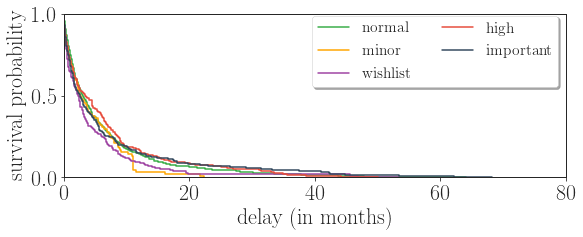

In [21]:
import lifelines
from lifelines.statistics import logrank_test
fig, ax = plt.subplots()

kmp_df = (
    arrival_after[['debianbug', 'arrival','severity','date']]
    .assign(duration=lambda d: (d['arrival'] - d['date']).dt.days / 30)
)

PALETTE = sns.color_palette(flatui)[:6] 
PALETTE_2 = sns.color_palette('Set3')[::-1]

kmp = lifelines.KaplanMeierFitter()
data = []
for i, severity in enumerate(arrival_after.severity.unique().tolist()):
#for i, severity in enumerate(['minor','high','important','normal']):

    mask = kmp_df['severity'] == severity
    kmp.fit(kmp_df[mask]['duration'], label=severity)
    print(severity, kmp.median_)
    kmp.plot(ax=ax, ci_show=False, color=PALETTE[i])

ax.set(
    xlim=(0, 80),
    xlabel='delay (in months)',
    ylim=(0, 1),
    ylabel='survival probability',
)
ax.figure.set_size_inches(9,3)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.04), fontsize=15.5, fancybox=True, shadow=True,ncol=2)


minor 4.0
serious 8.0
grave 17.0
critical 3.9
important 3.4
normal 3.466666666666667


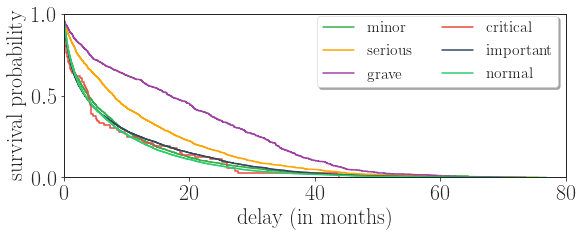

In [155]:
# Older figure, when considering all severities
import lifelines
from lifelines.statistics import logrank_test
fig, ax = plt.subplots()

kmp_df = (
    arrival_after[['debianbug', 'arrival','severity','date']]
    .assign(duration=lambda d: (d['arrival'] - d['date']).dt.days / 30)
)

PALETTE = sns.color_palette(flatui)[:6] 
PALETTE_2 = sns.color_palette('Set3')[::-1]

kmp = lifelines.KaplanMeierFitter()
data = []
for i, severity in enumerate(['minor','serious','grave','critical','important','normal']):
#for i, severity in enumerate(['minor','high','important','normal']):

    mask = kmp_df['severity'] == severity
    kmp.fit(kmp_df[mask]['duration'], label=severity)
    print(severity, kmp.median_)
    kmp.plot(ax=ax, ci_show=False, color=PALETTE[i])

ax.set(
    xlim=(0, 80),
    xlabel='delay (in months)',
    ylim=(0, 1),
    ylabel='survival probability',
)
ax.figure.set_size_inches(9,3)
ax.legend(loc='upper right', bbox_to_anchor=(1, 1.04), fontsize=15.5, fancybox=True, shadow=True,ncol=2)
